In [ ]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from langgraph.types import Command
from PyPDF2 import PdfReader


llm = init_chat_model("openai:gpt-5-nano-2025-08-07")

In [7]:
class State(TypedDict):
    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str


In [ ]:
def get_summary(state: State) -> State:
    response = llm.invoke(
        f"Write a summary of the following document: {state['document']}"
    )

    return {"summary": response.content}


def get_sentiment(state: State) -> State:
    response = llm.invoke(
        f"Analyze the sentiment of the following document: {state['document']}"
    )

    return {"sentiment": response.content}


def get_key_points(state: State) -> State:
    response = llm.invoke(
        f"Extract the key points of the following document: {state['document']}"
    )

    return {"key_points": response.content}


def get_recommendation(state: State) -> State:
    response = llm.invoke(
        f"Based on the following document, provide a recommendation for the user: {state['document']}"
    )

    return {"recommendation": response.content}


def get_final_analysis(state: State) -> State:
    response = llm.invoke(f"""
    Based on the following document, provide a final analysis:
    Summary: {state.get("summary", "N/A")}
    Sentiment: {state.get("sentiment", "N/A")}
    Key Points: {state.get("key_points", "N/A")}
    Recommendation: {state.get("recommendation", "N/A")}

    한글로 분석
    """)

    return {"final_analysis": response.content}

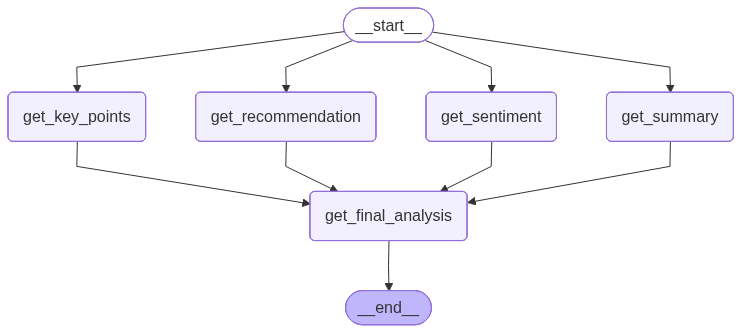

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("get_summary", get_summary)
graph_builder.add_node("get_sentiment", get_sentiment)
graph_builder.add_node("get_key_points", get_key_points)
graph_builder.add_node("get_recommendation", get_recommendation)
graph_builder.add_node("get_final_analysis", get_final_analysis)


graph_builder.add_edge(START, "get_summary")
graph_builder.add_edge(START, "get_sentiment")
graph_builder.add_edge(START, "get_key_points")
graph_builder.add_edge(START, "get_recommendation")

graph_builder.add_edge("get_summary", "get_final_analysis")
graph_builder.add_edge("get_sentiment", "get_final_analysis")
graph_builder.add_edge("get_key_points", "get_final_analysis")
graph_builder.add_edge("get_recommendation", "get_final_analysis")
graph_builder.add_edge("get_final_analysis", END)


graph = graph_builder.compile()

graph


In [ ]:
with open("2025-National-Security-Strategy.pdf", "rb") as f:
    pdf_reader = PdfReader(f)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()


for chunk in graph.stream({"document": text}, stream_mode="updates"):
    print(chunk, "\n")

NameError: name 'graph' is not defined